# Predictive Coding

Following Rao&Ballard1999, consider a multi-layered recurrent network of rate neurons, where the first layer $I$ represents the input to the system, and the remaining layers $x_i$ are the representations of that input.
<img src="../../img/predictive-rao-ballard-1.png" title="img1" style="height:80px">

The connections in the above network are not shown, as we will derive them mathematically. The main constraint of R&B is that a good approximation of each representation $x_i$, including the input, can be computed from the previous layer using a matrix multiplication and a nonlinearity (e.g. sigmoid), namely $\hat{x_i} = \sigma(U_i x_{i+1}) + \nu$, where $\nu$ is the possible
<img src="../../img/predictive-rao-ballard-2.png" title="img2" style="height:100px">

As such, the system must evolve to minimize the error of its predictive power. The global squared error is given by

$$E^2
= \sum_i \epsilon_i^2
= \sum_i |r_{i} - \hat{r}_{i}|^2
= \sum_i |r_{i} - U_i r_{i+1}|^2
$$

Any given representation $r_i$ has two contributions to the global error: $\epsilon_{i-1}$ determines the efficiency of the representation $r_i$ to predict the previous layer, and $\epsilon_{i}$ the efficiency of being predictable by the next layer. The dynamics of each layer can then be computed as via a gradient descent of the error function

$$\begin{eqnarray}
\tau_i \dot{x}_i
&=& -\frac{1}{2}\partial_{x_i} E^2 \\
&=& -\frac{1}{2}\partial_{x_i} (\epsilon_{i-1}^2 +  \epsilon_{i}^2) \\
&=& U_{i-1}^T \epsilon_{i-1} \sigma'(U_{i-1}x_i) - \epsilon_i \\
&=& U_{i-1}^T (x_{i-1} - \sigma(U_{i-1}x_i)) \sigma'(U_{i-1}x_i) - (r_{i} - \sigma(U_i x_{i+1})) \\
&=& -x_{i} + U_{i-1}^T x_{i-1} \sigma'(U_{i-1}x_i) + \sigma(U_i x_{i+1}) - U_{i-1}^T \sigma(U_{i-1}x_i) \sigma'(U_{i-1}x_i)
\end{eqnarray}$$

For simplicity, choose a linear function $\sigma(x) = x$, then $\sigma'(x) = 1$, and the dynamics equation can be rewritten as

$$\tau_i \dot{x}_i = -x_{i} + U_{i-1}^T x_{i-1} + U_i x_{i+1} - U_{i-1}^T U_{i-1}x_i$$

The terms of the RHS can be identified as leak, forwards-propagated representation, backwards-propagated representation, and self-inhibition. If we introduce the auxiliary inhibitory populations $i_i$, we can now draw the connectivity
<img src="../../img/predictive-rao-ballard-3.png" title="img3" style="height:150px">

Gradient descent can also be used to compute the plasticity rule for optimizing the representation matrix

$$\begin{eqnarray}
\tau_{U_i} \dot{U}_i
&=& -\frac{1}{2}\partial_{U_i} E^2
= -\frac{1}{2}\partial_{U_i} \epsilon_{i}^2 \\
&=& (x_{i} - \sigma(U_{i} x_{i+1})) \sigma'(U_{i}x_{i+1}) x_{i+1}^T \\
&=& x_{i} x_{i+1}^T \sigma'(U_{i}x_{i+1}) - \sigma(U_{i} x_{i+1})x_{i+1}^T \sigma'(U_{i}x_{i+1})
\end{eqnarray}$$

Again, assuming $\sigma(x) = x$, we can simplify the plasitcity rule to
$$\tau_{U_i} \dot{U}_i = x_{i} x_{i+1}^T - U_{i} x_{i+1} x_{i+1}^T$$
It is a form of Hebbian plasticity

**Criticism**:
* Same matrix weights $U_i$ appears 4 times in the design, but plasticity rule only given for the feedback weight.
* Feedforward and Feedback connectivity is symmetric.
* Connectivity $U_i$ is dense.
* The equation for highest layer are different than for the rest, as it does not receive input from above. Thus it does not have a natural leak term. Perhaps a leak term can be extracted by decomposing it from the self-inhibition, but that is only possible if the self-inhibition is at least as strong as the leak would be. Point being, it is not obvious that the equations selected to govern the last layer are consistent with the ones of rate-based neurons.
* The above equations do not take into account synaptic lags

**TODO**:
* Implement exact version of above, see if it really works
* Continue with Bogacz2017
* Add priors from R&B, understand what they do (low priority)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Naive implementation - Shallow - 0.1


$$\tau_x \dot{x} = U^T I - U^T U x$$

$$\tau_{U} \dot{U} = I x^T - U x x^T$$

**Conclusions-Shallow**:
* Can't learn to distinguish 2 textures with 1 latent variable (expected)
* Can learn to perfectly distinguish 2 textures with 2 latent variables (expected)
* Learning does not happen if each texture is presented for $T \gg \tau_U$ - otherwise overtraining results in forgetting of prev. results (expected)
* Learning does not happen if $T < 10 \tau_x$ - otherwise network never achieves steady state, and most updates to $U$ are due to some transitional values of $x$ which are not correct (expected)

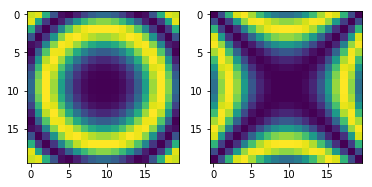

Initial norms 0.9999999999999999 1.0 1.0


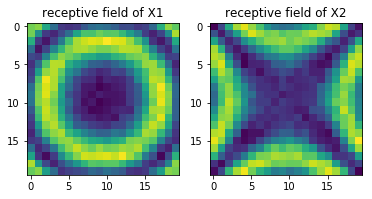

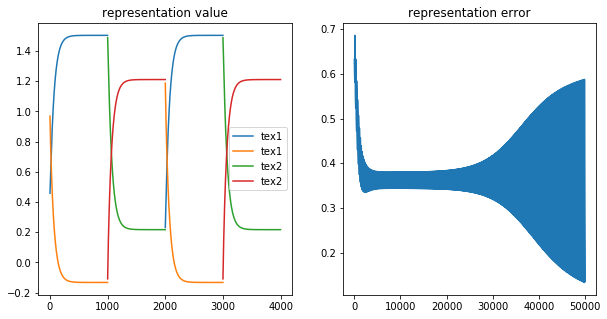

In [5]:
# Implementation of v1

##################################
# Generate some random pictures
##################################
NPIX_X = 20
discr = np.linspace(0, 1, NPIX_X)
pic1 = np.array([[np.sin(10*((x-0.5)**2+(y-0.5)**2))**2 for y in discr] for x in discr])
pic2 = np.array([[np.sin(10*((x-0.5)**2-(y-0.5)**2))**2 for y in discr] for x in discr])
pic1 /= np.linalg.norm(pic1)
pic2 /= np.linalg.norm(pic2)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(pic1)
ax[1].imshow(pic2)
plt.show()

##################################
# Write down update rules
##################################

def update_x(x, U, I, p):
    zeta_x = p['dt'] / p['tau_x']
    xnew = x + zeta_x * U.transpose().dot(I - U.dot(x))
    return xnew

def update_U(x, U, I, p):
    zeta_U = p['dt'] / p['tau_U']
    Unew = U + zeta_U * ( np.outer(I, x) - U.dot(np.outer(x, x)) )
    return Unew

##################################
# Initialize model
##################################

param = {'dt' : 0.0001, 'tau_x' : 0.001, 'tau_U' : 0.1}
N_INP = NPIX_X**2
N_X = 2

x = np.random.uniform(0.4, 0.6, N_X)
I_lst = [pic1.flatten(), pic2.flatten()] 
U = np.random.uniform(0, 1, N_INP*N_X).reshape((N_INP, N_X))
U /= np.linalg.norm(U)

print("Initial norms", np.linalg.norm(U), np.linalg.norm(I_lst[0]), np.linalg.norm(I_lst[1]))

times_lst = []
x_lst = [[],[]]
err = []

# Training
for i in range(50000):
    idx_I = (i // 100) % 2
    I_this = I_lst[idx_I]# + np.random.normal(0, 0.01, N_INP)
    x = update_x(x, U, I_this, param)
    U = update_U(x, U, I_this, param)
    
# Testing
for i in range(4000):
    idx_I = (i // 1000) % 2
    I_this = I_lst[idx_I]# + np.random.normal(0, 0.01, N_INP)
    x = update_x(x, U, I_this, param)
    times_lst.append(i)
    x_lst[idx_I].append(np.copy(x))
    x_lst[1-idx_I].append(np.zeros(N_X) + np.nan)
    err.append(np.linalg.norm(I_this - U.dot(x)))
    
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(U[:,0].reshape((NPIX_X, NPIX_X)))
ax[1].imshow(U[:,1].reshape((NPIX_X, NPIX_X)))
ax[0].set_title("receptive field of X1")
ax[1].set_title("receptive field of X2")
plt.show()
    
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].plot(times_lst, x_lst[0], label='tex1')
ax[0].plot(times_lst, x_lst[1], label='tex2')
ax[0].legend()
ax[0].set_title("representation value")
ax[1].plot(err)
ax[1].set_title("representation error")
plt.show()

## Naive implementation - Shallow - 0.2

Step 1: Place error into a separate node. So far, the results of this model would be exactly the same as for the model above
$$\begin{eqnarray}
    \epsilon = I -  U x\\
    \tau_i \dot{x} = U^T \epsilon\\
    \tau_{U} \dot{U} = \epsilon x^T
\end{eqnarray}$$

Step 2: Notice that neither $e$ nor $x$ conform to the definition of a rate neuron, as they do not have a leak term
$$\begin{eqnarray}
    \tau_\epsilon \dot{\epsilon} = - \epsilon + I -  U x\\
    \tau_i \dot{x} = U^T \epsilon\\
    \tau_{U} \dot{U} = \epsilon x^T
\end{eqnarray}$$

**Conclusions**:

Initial norms 1.0 1.0 1.0


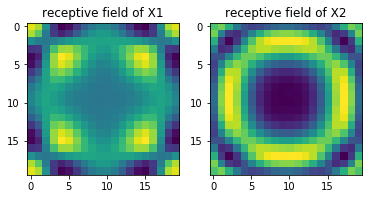

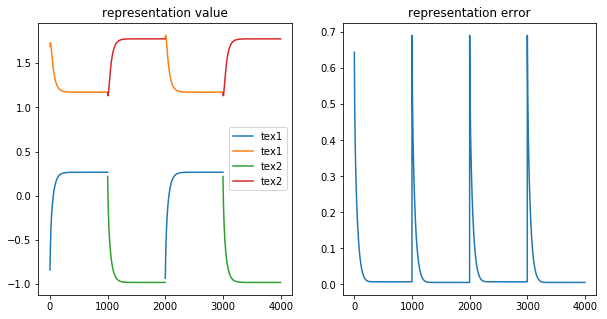

In [4]:
##################################
# Write down update rules
##################################

def update_x(x, U, I, p):
    e = I - U.dot(x)
    zeta_x = p['dt'] / p['tau_x']
    xnew = x + zeta_x * U.transpose().dot(e)
    return xnew

def update_U(x, U, I, p):
    zeta_U = p['dt'] / p['tau_U']
    Unew = U + zeta_U * ( np.outer(I, x) - U.dot(np.outer(x, x)) )
    return Unew

##################################
# Initialize model
##################################

param = {'dt' : 0.0001, 'tau_x' : 0.001, 'tau_U' : 0.1}
N_INP = NPIX_X**2
N_X = 2

x = np.random.uniform(0.4, 0.6, N_X)
I_lst = [pic1.flatten(), pic2.flatten()] 
U = np.random.uniform(0, 1, N_INP*N_X).reshape((N_INP, N_X))
U /= np.linalg.norm(U)

print("Initial norms", np.linalg.norm(U), np.linalg.norm(I_lst[0]), np.linalg.norm(I_lst[1]))

times_lst = []
x_lst = [[],[]]
err = []

# Training
for i in range(50000):
    idx_I = (i // 100) % 2
    I_this = I_lst[idx_I]# + np.random.normal(0, 0.01, N_INP)
    x = update_x(x, U, I_this, param)
    U = update_U(x, U, I_this, param)
    
# Testing
for i in range(4000):
    idx_I = (i // 1000) % 2
    I_this = I_lst[idx_I]# + np.random.normal(0, 0.01, N_INP)
    x = update_x(x, U, I_this, param)
    times_lst.append(i)
    x_lst[idx_I].append(np.copy(x))
    x_lst[1-idx_I].append(np.zeros(N_X) + np.nan)
    err.append(np.linalg.norm(I_this - U.dot(x)))
    
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(U[:,0].reshape((NPIX_X, NPIX_X)))
ax[1].imshow(U[:,1].reshape((NPIX_X, NPIX_X)))
ax[0].set_title("receptive field of X1")
ax[1].set_title("receptive field of X2")
plt.show()
    
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].plot(times_lst, x_lst[0], label='tex1')
ax[0].plot(times_lst, x_lst[1], label='tex2')
ax[0].legend()
ax[0].set_title("representation value")
ax[1].plot(err)
ax[1].set_title("representation error")
plt.show()